In [1]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code integrates the following concepts:
#  - Infinite system algorithm
#  - Finite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
from scipy.linalg import logm
from IPython.display import clear_output

# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

# This function should test the same exact things, so there is no need to
# repeat its definition.
is_valid_enlarged_block = is_valid_block

def get_von_neuman_entr(rho):
    """
    returns the von neuman entropy of a density matrix rho
    """
    return - np.trace(rho.dot(logm(rho)))

Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

class bose_Hubbard:
    def __init__(self, N_max, J=1, mu=1, U=1, filling=1, corr_size=20) -> None:
        self.N_max = N_max
        self.J = J
        self.mu = mu
        self.U = U
        self.b = np.diag(np.sqrt(np.arange(1, N_max)), k=1)
        self.b_dag = self.b.transpose()
        self.n_op = np.diag(np.arange(0,N_max))
        self.p_N = np.zeros([N_max, N_max], dtype="d")
        self.p_N[filling, filling] = 1
        self.filling = filling
        self.g = 1
        self.corr_size = corr_size
        
        self.H1 = U/2 * np.matmul(self.n_op, self.n_op - identity(N_max)) - mu * self.n_op

        self.initial_block = Block(length=1, basis_size=N_max, operator_dict={
            "_H": self.H1,
            "_b": self.b,
            "_N": self.n_op,
            "_p_N": self.p_N,
        })
        pass

    def H_int(self, b_left, b_right):
        return - self.J * ( b_left.transpose().dot( b_right ) + b_right.transpose().dot( b_left ) )
        #return J * ( kron(b_l.transpose(), b_r ) + kron( b_r.transpose(), b_l ) )


    def enlarge_block(self, block):
        """This function enlarges the provided Block by a single site, returning an
        EnlargedBlock.
        """
        mblock = block.basis_size
        o = block.operator_dict

        # Create the new operators for the enlarged block.  Our basis becomes a
        # Kronecker product of the Block basis and the single-site basis.  NOTE:
        # `kron` uses the tensor product convention making blocks of the second
        # array scaled by the first.  As such, we adopt this convention for
        # Kronecker products throughout the code.
        enlarged_operator_dict = {
            "_H": kron(o["_H"], identity(self.N_max)) + kron(identity(mblock), self.H1) + self.H_int(kron(o["_b"], identity(self.N_max)), kron(identity(mblock), self.b)),
            "_b": kron(identity(mblock), self.b),
            "_N": kron(o["_N"], identity(self.N_max)) + kron(identity(mblock), self.n_op),
            "_p_N": kron(o["_p_N"], identity(self.N_max)) + kron(identity(mblock), self.p_N)
        }

        return EnlargedBlock(length=(block.length + 1),
                            basis_size=(block.basis_size * self.N_max),
                            operator_dict=enlarged_operator_dict)

    def rotate_and_truncate(self, operator, transformation_matrix):
        """Transforms the operator to the new (possibly truncated) basis given by
        `transformation_matrix`.
        """
        return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

    def single_dmrg_step(self, sys, env, m):
        """Performs a single DMRG step using `sys` as the system and `env` as the
        environment, keeping a maximum of `m` states in the new basis.
        """
        assert is_valid_block(sys)
        assert is_valid_block(env)

        # Enlarge each block by a single site.
        sys_enl = self.enlarge_block(sys)
        if sys is env:  # no need to recalculate a second time
            env_enl = sys_enl
        else:
            env_enl = self.enlarge_block(env)

        assert is_valid_enlarged_block(sys_enl)
        assert is_valid_enlarged_block(env_enl)

        # Construct the full superblock Hamiltonian.
        m_sys_enl = sys_enl.basis_size
        m_env_enl = env_enl.basis_size
        sys_enl_op = sys_enl.operator_dict
        env_enl_op = env_enl.operator_dict
        
        superblock_hamiltonian = kron(sys_enl_op["_H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["_H"]) + \
                                self.H_int(kron(sys_enl_op["_b"], identity(m_env_enl)), kron(identity(m_sys_enl) , env_enl_op["_b"]))

        # Call ARPACK to find the superblock ground state.  ("SA" means find the
        # "smallest in amplitude" eigenvalue.)
        #print(sys_enl_op["_p_N"])
        #selecting_N = kron(sys_enl_op["_p_N"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["_p_N"])
        #superblock_hamiltonian_aus = selecting_N.transpose().conjugate().dot(superblock_hamiltonian.dot(selecting_N))

        N_op_glob = kron(sys_enl_op["_N"], identity(m_env_enl)) + kron(identity(m_sys_enl) , env_enl_op["_N"])
        L_aus = sys_enl.length + env_enl.length

        matrix_aus = self.filling*L_aus*identity(m_env_enl*m_sys_enl) - N_op_glob
        #print("non-zeros of matrix_aus = ", matrix_aus.nnz)
        rows_, cols_ = matrix_aus.shape
        #print("zeros of matrix_aus = ", rows_*cols_ - matrix_aus.nnz)
        superblock_hamiltonian_aus = superblock_hamiltonian + self.g*matrix_aus.dot(matrix_aus)
        #print("creato superblok aus")
        (energy,), psi0 = eigsh(superblock_hamiltonian_aus, k=1, which="SA")
        #print("trovato autostato globale")
        # Construct the reduced density matrix of the system by tracing out the
        # environment
        #(energy_max,), psi1 = eigsh(superblock_hamiltonian_aus, k=1, which="LA")
        #print(energy, energy_max)

        # We want to make the (sys, env) indices correspond to (row, column) of a
        # matrix, respectively.  Since the environment (column) index updates most
        # quickly in our Kronecker product structure, psi0 is thus row-major ("C
        # style").
        psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
        rho = np.dot(psi0, psi0.conjugate().transpose())
        self.rho_for_corr = rho
        
        print("calcolata matrice densità del sistema")
        #selecting_N = sys_enl_op["_p_N"].toarray()
        #rho = selecting_N.conjugate().transpose().dot(rho).dot(selecting_N)
        # get the von neuman entropy of a subsystem with size L_a = L/2
        #entropy = get_von_neuman_entr(rho)

        # Diagonalize the reduced density matrix and sort the eigenvectors by
        # eigenvalue.
        evals, evecs = np.linalg.eigh(rho)
        possible_eigenstates = []
        for eval, evec in zip(evals, evecs.transpose()):
            N = evec.dot(sys_enl_op["_N"].dot(evec))
            #print("eval = ", eval, " ; N = %.2f"%N)
            #if N > sys_enl.length-0.2 and N < sys_enl.length+0.2:
            possible_eigenstates.append((eval, evec))
        possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

        # Build the transformation matrix from the `m` overall most significant
        # eigenvectors.
        my_m = min(len(possible_eigenstates), m)
        transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
        for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
            transformation_matrix[:, i] = evec
        self.transf_matrix = transformation_matrix

        truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
        print("truncation error:", truncation_error)

        # Rotate and truncate each operator.
        new_operator_dict = {}
        for name, op in sys_enl.operator_dict.items():
            new_operator_dict[name] = self.rotate_and_truncate(op, transformation_matrix)

        newblock = Block(length=sys_enl.length,
                        basis_size=my_m,
                        operator_dict=new_operator_dict)

        entropy = np.sum([-i[0]*np.log(i[0]) for i in possible_eigenstates if i[0]>10**(-10)])
        #entropy_2 = get_von_neuman_entr(rho)

        return newblock, energy, entropy

    def graphic(self, sys_block, env_block, sys_label="l"):
        """Returns a graphical representation of the DMRG step we are about to
        perform, using '=' to represent the system sites, '-' to represent the
        environment sites, and '**' to represent the two intermediate sites.
        """
        assert sys_label in ("l", "r")
        graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
        if sys_label == "r":
            # The system should be on the right and the environment should be on
            # the left, so reverse the graphic.
            graphic = graphic[::-1]
        return graphic

    def infinite_system_algorithm(self, L, m):
        self.L = L
        block = self.initial_block
        # Repeatedly enlarge the system by performing a single DMRG step, using a
        # reflection of the current block as the environment.
        while 2 * block.length < L:
            print("L =", block.length * 2 + 2)
            block, energy, _ = self.single_dmrg_step(block, block, m=m)
            print("E/L =", energy / (block.length * 2))

    def finite_system_algorithm(self, L, m_warmup, m_sweep_list):
        assert L % 2 == 0  # require that L is an even number

        energies = []
        entropies = []
        # To keep things simple, this dictionary is not actually saved to disk, but
        # we use it to represent persistent storage.
        block_disk = {}  # "disk" storage for Block objects

        # Use the infinite system algorithm to build up to desired size.  Each time
        # we construct a block, we save it for future reference as both a left
        # ("l") and right ("r") block, as the infinite system algorithm assumes the
        # environment is a mirror image of the system.
        block = self.initial_block
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

        # update the lists of operators for correlators calculation
        self._corr_ops = []
        self._corr_op_L = 0

        while 2 * block.length < L:
            clear_output(wait=True)
            # Perform a single DMRG step and save the new Block to "disk"
            print(block.length)
            print(self.graphic(block, block))
            block, energy, entropy = self.single_dmrg_step(block, block, m=m_warmup)
            print("E/L =", energy / (block.length * 2))
            block_disk["l", block.length] = block
            block_disk["r", block.length] = block

            if block.length > int(L/2) - self.corr_size and block.length != int(L/2):
                new_ops = []
                for op in self._corr_ops:
                    new_ops.append(self.rotate_and_truncate(kron(op, np.eye(self.N_max)), self.transf_matrix))
                self._corr_ops = new_ops

                self._corr_ops.append(block.operator_dict["_b"])

            elif block.length == int(L/2):
                print("LA LUNGHEZZA del blocco sinistro E' L/2 ", int(L/2))
                self._corr_ops.append(block.operator_dict["_b"])
                new_ops = []
                for op in self._corr_ops:
                    new_ops.append(self.rotate_and_truncate(kron(op, self.b_dag), self.transf_matrix))
                self._corr_ops = new_ops


        # Now that the system is built up to its full size, we perform sweeps using
        # the finite system algorithm.  At first the left block will act as the
        # system, growing at the expense of the right block (the environment), but
        # once we come to the end of the chain these roles will be reversed.
        sys_label, env_label = "l", "r"
        sys_block = block; del block  # rename the variable
        for m in m_sweep_list:
            while True:
                # Load the appropriate environment block from "disk"
                env_block = block_disk[env_label, L - sys_block.length - 2]
                if env_block.length == 1:
                    # We've come to the end of the chain, so we reverse course.
                    sys_block, env_block = env_block, sys_block
                    sys_label, env_label = env_label, sys_label

                clear_output(wait=True)
                print(env_block.length, "+", sys_block.length, "=", env_block.length+sys_block.length)
                # Perform a single DMRG step.
                print(self.graphic(sys_block, env_block, sys_label))
                sys_block, energy, entropy = self.single_dmrg_step(sys_block, env_block, m=m)

                # rotate and troncate the operators for the correlation
                #aus_new_ops = []
                #for i, op in enumerate(self._corr_ops):
                #    print(op)
                #    print(self.transf_matrix)
                #    aus_new_ops.append(self.rotate_and_truncate(op, self.transf_matrix))
                #self._corr_ops = aus_new_ops

                print("E/L =", energy / L)
                
                energies.append(energy)
                entropies.append(entropy)
                # Save the block from this step to disk.
                block_disk[sys_label, sys_block.length] = sys_block

                # Check whether we just completed a full sweep.
                if sys_label == "l" and 2 * sys_block.length == L:
                    break  # escape from the "while True" loop
        
        correlators = []
        for op in self._corr_ops:
            correlators.append(np.trace(kron(op, np.eye(self.N_max)).dot(self.rho_for_corr)))

        return np.array(energies), np.array(entropies), np.array(correlators)[::-1]
#if __name__ == "__main__":
#    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    #infinite_system_algorithm(L=100, m=20)
#    finite_system_algorithm(L=20, m_warmup=20, m_sweep_list=[20, 30, 40, 40])

In [2]:
U = 1
mu = 0.4
Js = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

N_max = 4
L = 120
m = 10
m_sweep = [10,10]

corrs_s = []

In [3]:
for J in Js:
    my_DMRG = bose_Hubbard(N_max, J, mu, U)
    ens, entrs, corrs = my_DMRG.finite_system_algorithm(L, m, m_sweep)
    corrs[0] = 1
    corrs_s.append(corrs)

22 + 96 = 118
================================================================================================**----------------------


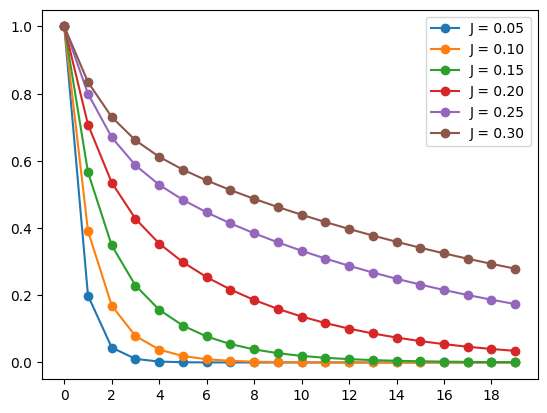

In [ ]:
for i, J in enumerate(Js):    
    plt.plot(corrs_s[i], linestyle="-", marker="o",label = "J = %.2f"%J)
plt.legend()
plt.xticks(np.arange(0,19,step=2))
plt.show()

In [ ]:
file = open("dati/correlators_mu04_Nmax4_m_10_.txt", "w")

In [ ]:
for i, J in enumerate(Js):
    file.write(str(J))
    file.write(" ")
    for j in range(20):
        file.write(str(corrs_s[i][j]))
        file.write(" ")
    file.write("\n")

In [ ]:
file.close()